In [5]:
# %% [markdown]
# # Empirical Next-Token Entropy Distribution
# This notebook computes the distribution of next-token entropies for a pretrained language model (e.g., BERT, GPT-2) over a sliding window of length `k`.

# %%
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# %% [markdown]
# ## Parameters

# %%


# %% [markdown]
# ## Summary
# - `entropies` array contains the empirical next-token entropy values for each sliding window.
# - You can adjust `WINDOW_SIZE`, `MAX_TOKENS`, or the input `TEXT_SAMPLE` to explore different sequences.
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")


GPU Name: NVIDIA GeForce RTX 3070


  0%|          | 0/5 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 20%|██        | 1/5 [00:04<00:17,  4.37s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 40%|████      | 2/5 [00:08<00:12,  4.33s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 60%|██████    | 3/5 [00:12<00:08,  4.30s/it]The attention mask and the pad token id were not set. As a consequence, you

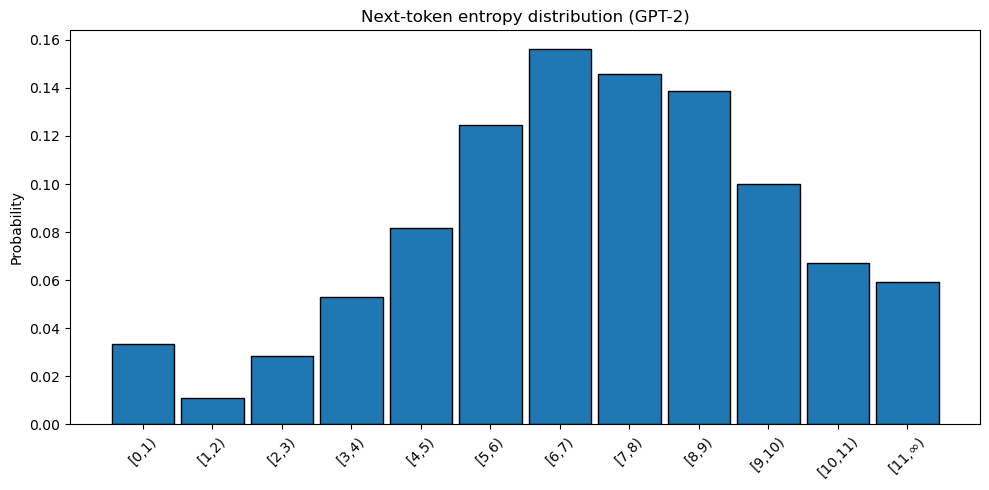

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

MODEL_NAME = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

WINDOW_SIZE = 4
TOKENS_PER_PROMPT = 200
NUM_PROMPTS = 5

REAL_TEXT_SAMPLES = [
    "In a distant future, humanity has spread across the stars.",
    "The quick brown fox jumps over the lazy dog and runs into the forest.",
    "Mathematics provides a language for describing complex systems.",
    "The history of information theory begins with Claude Shannon.",
    "Artificial intelligence models learn patterns from massive datasets."
]

def compute_next_token_entropy_bits(model, context_tokens):
    with torch.no_grad():
        logits = model(context_tokens.unsqueeze(0)).logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)[0]
        ent = -(probs * (probs + 1e-12).log()).sum()
        return float(ent / np.log(2))

all_entropies_bits = []

for _ in tqdm(range(NUM_PROMPTS)):
    prompt = np.random.choice(REAL_TEXT_SAMPLES)
    toks = tokenizer(prompt, return_tensors="pt")["input_ids"][0].to(device)

    needed = max(0, TOKENS_PER_PROMPT - len(toks))
    if needed > 0:
        with torch.no_grad():
            out = model.generate(
                toks.unsqueeze(0),
                max_new_tokens=needed,
                do_sample=True,
                top_p=0.9
            )[0]
        toks = out.to(device)
    else:
        toks = toks[:TOKENS_PER_PROMPT]

    # sliding window
    for i in range(WINDOW_SIZE, len(toks)):
        window = toks[i-WINDOW_SIZE:i]
        H = compute_next_token_entropy_bits(model, window)
        all_entropies_bits.append(H)

all_entropies_bits = np.array(all_entropies_bits)

bin_edges = np.array([0,1,2,3,4,5,6,7,8,9,10,11,np.inf])
bin_labels = np.array(["[0,1)","[1,2)","[2,3)","[3,4)","[4,5)","[5,6)",
                       "[6,7)","[7,8)","[8,9)","[9,10)","[10,11)","[11,∞)"])

counts, _ = np.histogram(all_entropies_bits, bins=bin_edges)
probs = counts / counts.sum()

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(probs)), probs, width=0.9, edgecolor="black")
plt.xticks(np.arange(len(probs)), bin_labels, rotation=45)
plt.ylabel("Probability")
plt.title("Next-token entropy distribution (GPT-2)")
plt.tight_layout()
plt.show()





In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

# ---- Tokenizer ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# ---- Model loading with offloading support ----
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,     # important
    device_map="auto",          # auto-shard across CPU/GPU
    offload_folder="offload",   # where to offload layers
    offload_state_dict=True,
)
model.eval()

prompt = "Explain quantum mechanics in one paragraph."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.9,
        temperature=0.9,
    )

print(tokenizer.decode(output[0], skip_special_tokens=True))



`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Explain quantum mechanics in one paragraph. A quantum object can be in multiple states at once and can exist in two places at once. Quantum objects can have waves and can be affected by each other even if they are far apart. The observer affects the state of the quantum object and can collapse the wave function. The math behind quantum mechanics is based on probability and is very complex.
Quantum mechanics is a branch of physics that deals with the behavior of matter and energy at an atomic and subatomic level. It describes the physical properties of particles
